## Import statements

In [1]:
import numpy as np
from distgen import Generator
from impact import Impact, run_impact_with_distgen, evaluate_impact_with_distgen
from impact.autophase import autophase_and_scale
import os
from pmd_beamphysics import single_particle, ParticleGroup

## Get Conda path and add to system path

In [2]:
env_name = 'NERSC_Impact-T_Example' # From yml file, but change this if you change envs

conda_envs = os.popen("module load conda; conda info --envs").read() 
conda_path = conda_envs.split('\n'+ env_name)[1]
path = conda_path.strip()
path = path.split('\n')[0]
path = path + '/bin/'
os.environ["PATH"] += os.pathsep + path

## Define inputs (set numprocs to 1 if you want single core!)
numprocs cannot be large for smaller simulations (if you get an error with parallelization, decrease numprocs)

In [3]:
# Get Input Files
GFILE = os.path.expandvars('distgen.yaml') # Distgen input file
YFILE_TEMPLATE = os.path.expandvars('ImpactT-template.yaml') #Initial settings

# Manual Conversions
L0AF_E_Gain = 62924849.46502216 # Calculated L0AF energy gain from January 2024 nominal power readbacks
sim_sol_conv = 1.6 #Convert from PV value to T/m (simulation input)
L0AF_Phase = 0 #L0AF phase; 0 is max E phase

#Impact settings
SETTINGS0 = {
    'numprocs':128,#(len(os.sched_getaffinity(0)))-1, #Number of available cores, minus one (jupyter is running in one core)
    'header:Nx':32,
    'header:Ny':32,  
    'header:Nz':32, 
    'stop_1:s':4.2,
    'distgen:n_particle':2e5,
    'GUNF:theta0_deg':29.3-90,#31.83 degrees-adjustment for phase def.
    'GUNF:rf_field_scale': 119/2.44885*1e6,
    'SOL10111:solenoid_field_scale':-0.41/sim_sol_conv,
    'PR10241:sample_frequency':1,
    'workdir': os.environ.get('SCRATCH', '/opt/scratch'),
    'command': path + 'ImpactTexe',    
    'command_mpi': path + 'ImpactTexe-mpi',
    # 'mpi_run':'mpirun --map-by :OVERSUBSCRIBE -n {nproc} {command_mpi}'
    # 'mpi_run':'run -n {nproc} {command_mpi}'
    # 'mpi_run':'./ImpactTexe-mpi'
    'mpi_run':'mpiexec --map-by :OVERSUBSCRIBE -n {nproc} {command_mpi}'

}

## Set environment variables

In [4]:
os.environ['FACET2_LATTICE']=os.path.expanduser(os.getcwd()+'/facet2-lattice')
# Access environment variables
facet2_lattice = os.environ.get('FACET2_LATTICE', 'Not set')
scratch = os.environ.get('SCRATCH', 'Not set')

print(f'Make sure environment was set!:  FACET2_LATTICE={facet2_lattice}')
print(f'Make sure environment was set!:  SCRATCH={scratch}')

# Validate environment variables
!echo $FACET2_LATTICE
!echo $SCRATCH

Make sure environment was set!:  FACET2_LATTICE=/global/u2/c/cropp/NERSC_Impact-T_Example/facet2-lattice
Make sure environment was set!:  SCRATCH=/pscratch/sd/c/cropp
/global/u2/c/cropp/NERSC_Impact-T_Example/facet2-lattice
/pscratch/sd/c/cropp


## Helper functions to update settings

In [5]:
def update_distgen(G,settings=None,verbose=False):
    G.verbose=verbose
    if settings:
        for key in settings:
            val = settings[key]
            if key.startswith('distgen:'):
                key = key[len('distgen:'):]
                if verbose:
                    print(f'Setting distgen {key} = {val}')
                G[key] = val
            
    
    # Get particles
    
    return G

def update_impact(I,settings=None,
               impact_config=None,
               verbose=False):
    
    I.verbose=verbose
    if settings:
        for key in settings:
            val = settings[key]
            if not key.startswith('distgen:'):
               # Assume impact
                if verbose:
                    print(f'Setting impact {key} = {val}')          
                I[key] = val                
   
    return I

## Copy Impact Input Files to Directory

In [6]:
!cp $FACET2_LATTICE/impact/models/f2e_inj/v0/ImpactT_template.in .
!cp $FACET2_LATTICE/impact/models/f2e_inj/v0/rfdata201 .
!cp $FACET2_LATTICE/impact/models/f2e_inj/v0/rfdata102 .
!cp $FACET2_LATTICE/impact/models/f2e_inj/v0/rfdata4 .
!cp $FACET2_LATTICE/impact/models/f2e_inj/v0/rfdata5 .
!cp $FACET2_LATTICE/impact/models/f2e_inj/v0/rfdata6 .
!cp $FACET2_LATTICE/impact/models/f2e_inj/v0/rfdata7 .

## Update Distgen and Impact Objects

In [7]:
I = Impact.from_yaml(YFILE_TEMPLATE)
G = Generator(GFILE)
I=update_impact(I,SETTINGS0)

## Autophase & Scale L0AF

In [8]:
I['L0AF_scale']['rf_field_scale']=30e6
I['L0AF_phase']['theta0_deg']=29
I.numprocs=1

E = 6e6

target_L0AF=E+L0AF_E_Gain

print(target_L0AF)

P0 = single_particle(pz=1e-15, z=1e-15)

res_L0AF = autophase_and_scale(I, phase_ele_name='L0AF_phase', scale_ele_name='L0AF_scale', target=target_L0AF, scale_range=(10e6, 100e6), initial_particles=P0, verbose=True)


68924849.46502216
Copied initial Impact object. 
Phasing L0AF_phase by changing theta0_deg
Scaling L0AF_scale by changing rf_field_scale
Bounds: 1.058398, 4.101254 m
Tracking initial particles to s = 1.058398
Initial particle:  1.05780943045 6111260.824797189
Disabling GUNF
Disabling SOL10111
Disabling L0BF_entrance
Disabling L0BF_body_1
Disabling L0BF_body_2
Disabling L0BF_exit
Default brent2 algorithm
Phase: 180, Scale: 10000000.0, 14.050170210264124 MeV
Phase: 180, Scale: 10000000.0, 14.050170210264124 MeV
Phase: 42.49224000000004, Scale: 10000000.0, 19.13951235115013 MeV
Phase: 264.9844890561601, Scale: 10000000.0, 9.26390394777396 MeV
Phase: 42.49223440298533, Scale: 10000000.0, 19.139513842906073 MeV
Phase: 264.9844709438398, Scale: 10000000.0, 9.26390063068617 MeV
Phase: 222.49226439130257, Scale: 10000000.0, 9.6957652427859 MeV
Phase: 127.47670402554945, Scale: 10000000.0, 8.743662912772326 MeV
Phase: 333.7383658575029, Scale: 10000000.0, 23.978258357956637 MeV
Phase: 291.24613

## Make initial distribution


In [9]:
G=update_distgen(G,SETTINGS0,verbose=True)
G.input
G.run()
P = G.particles
I.initial_particles = P

Setting distgen n_particle = 200000.0
Distribution format: None
Output file: None

Creating beam distribution....
   Beam starting from: cathode
   Total charge: 1600 pC.
   Number of macroparticles: 200000.
   xy distribution: 2D File PDF
      2D pdf file: /global/u2/c/cropp/NERSC_Impact-T_Example/VCC_March_2024.jpeg
      min_x = -2.808 mm, max_x = 2.808 mm
      min_y = -2.808 mm, max_y = 2.808 mm
   t distribution: Gaussian
      avg_t = 0 ps, sigma_t = 0.819 ps
      Left n_sigma_cutoff = 3, Right n_sigma_cutoff = -3
   px distribution: Gaussian
      avg_px = 0 eV/c, sigma_px = 452.106 eV/c
   py distribution: Gaussian
      avg_py = 0 eV/c, sigma_py = 452.106 eV/c
   pz distribution: Gaussian
      avg_pz = 0 eV/c, sigma_pz = 452.106 eV/c
   Shifting avg_x = -0.136641 mm -> -0.136641 mm
   Shifting avg_y = 0.101954 mm -> 0.101954 mm
   Shifting avg_px = -0.0385557 eV/c -> 0 eV/c
   Scaling sigma_px = 452.092 eV/c -> 452.106 eV/c
   Shifting avg_py = -0.0347037 eV/c -> 0 eV/c
  

## Run Impact-T

In [10]:
%%time 
I.numprocs=SETTINGS0['numprocs']
I.workdir = os.path.expandvars('$SCRATCH')
I.verbose=True
I.run()

Running Impact-T in /pscratch/sd/c/cropp/tmpb2g7j212
mpiexec --map-by :OVERSUBSCRIBE -n 128 /global/common/software/m4272/conda/NERSC_Impact-T_Example/bin/ImpactTexe-mpi
writing 200000 particles to /pscratch/sd/c/cropp/tmpb2g7j212/partcl.data
Cathode start with cathode_kinetic_energy_ref = 1.0 eV
Cathode start: Replaced Np with 200000 according to initial particles
Cathode start: Replaced Bkenergy with 1.0 according to initial particles
Cathode start: Replaced Temission with 4.911943721086833e-12 according to initial particles
Cathode start: Replaced Tini with -2.456275748121641e-12 according to initial particles
Setting total charge to 1.5999999999999996e-09 C
 !-----------------------------------------------------------
 ! IMPACT-T Parallel Beam Dynamics Tracking Code: V2.3.1
 ! Copyright of The Regents of the University of California
 !-----------------------------------------------------------
 nblem:           28          28
 pass setting up lattice...
 check randomness:          

## Archive results (commented as it is a large file -- but this is how)

In [11]:

# I.archive('test_beam.h5')

## Plot emittance as a function of position in beamline

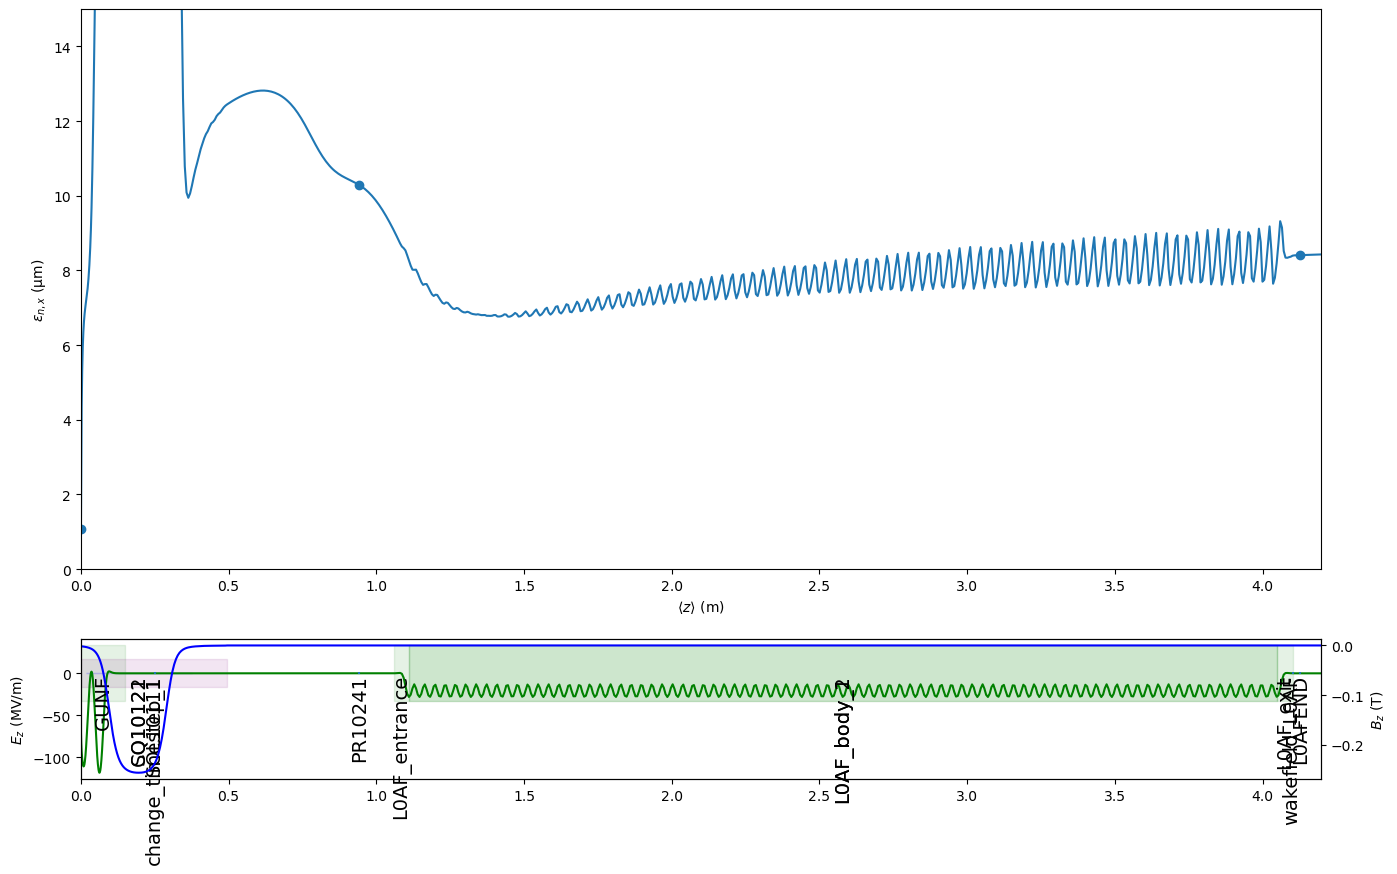

In [12]:
I['group']
I.plot('norm_emit_x', ylim=(0, 15e-6), figsize=(16,10), include_labels=True)

## Plot transverse profile

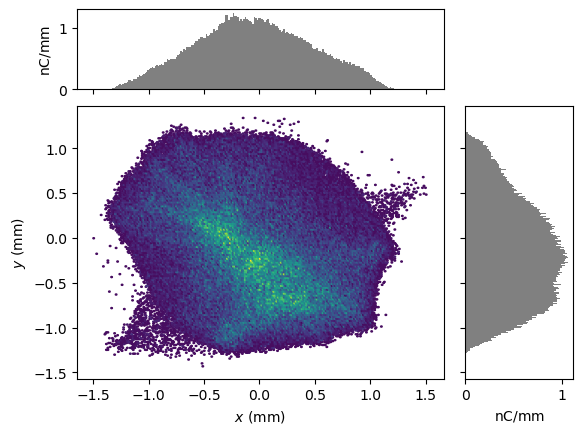

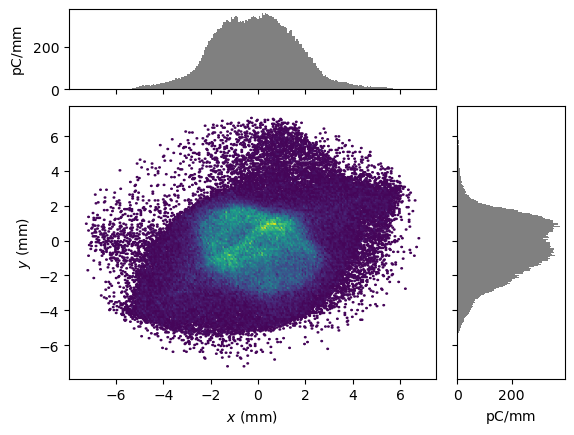

In [13]:
P1 = I.particles['PR10241']
P2 = I.particles['L0AFEND']

P1.plot('x','y')
P2.plot('x','y')

## Clean directory

In [14]:

!rm -rf ImpactT_template.in
!rm -rf rfdata201
!rm -rf rfdata102
!rm -rf rfdata4
!rm -rf rfdata5
!rm -rf rfdata6
!rm -rf rfdata7
!rm -rf ImpactT.yaml